### Recalculate ASC per transport accross slope. 
#### maybe use this is a baseline. https://github.com/COSIMA/cosima-recipes/blob/main/Recipes/Transport_Through_Straits.ipynb

In [5]:
import intake
import cf_xarray as cfxr
import cf_xarray.units
import pint_xarray
from pint import application_registry as ureg
import matplotlib.pyplot as plt
from dask.distributed import Client
import logging

import cosima_cookbook as cc
import warnings
warnings.filterwarnings("ignore")

In [2]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41081,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:34725,Total threads: 1
Dashboard: /proxy/42621/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:37713,


In [6]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
experiment = '01deg_jra55v140_iaf_cycle3'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

In [10]:
vars_025deg = cc.querying.get_variables(master_session, experiment)
vars_025deg[vars_025deg['name'].str.lower().str.contains('tx_trans')]

,name,long_name,units,frequency,ncfile,cell_methods,# ncfiles,time_start,time_end
250,tx_trans,T-cell i-mass transport,kg/s,1 monthly,output731/ocean/ocean-3d-tx_trans-1-monthly-mean-ym_2018_10.nc,time: mean,244,1958-01-01 00:00:00,2019-01-01 00:00:00
251,tx_trans_int_z,T-cell i-mass transport vertically summed,kg/s,1 monthly,output731/ocean/ocean-2d-tx_trans_int_z-1-monthly-mean-ym_2018_10.nc,time: mean,244,1958-01-01 00:00:00,2019-01-01 00:00:00
252,tx_trans_rho,T-cell i-mass transport on pot_rho,kg/s,1 monthly,output731/ocean/ocean-3d-tx_trans_rho-1-monthly-mean-ym_2018_10.nc,time: mean,38,2009-07-01 00:00:00,2019-01-01 00:00:00


### Defining transect

In [36]:
straits = {'ASC': [ -66,  -64, -251, -251]}

### LOAD DATA. It will have a one thousand warnings. 

In [114]:
trans_x

<xarray.DataArray 'tx_trans' (time: 732, st_ocean: 75, yt_ocean: 10)>
<Quantity(dask.array<getitem, shape=(732, 75, 10), dtype=float32, chunksize=(1, 19, 10), chunktype=numpy.ndarray>, 'kilogram / second')>
Coordinates:
    xu_ocean  float64 [degrees_east] -251.5
  * yt_ocean  (yt_ocean) float64 -65.18 -65.14 -65.1 ... -64.89 -64.85 -64.8
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) datetime64[ns] 1958-01-16T12:00:00 ... 2018-12-16T12:00:00
Attributes:
    long_name:      T-cell i-mass transport
    valid_range:    [-1.e+20  1.e+20]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  ocean_mass_x_transport
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2020-11-11
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...

#### Calculate density to include in transport calculation

In [115]:
ρ0 = 1036 * ureg.kilogram / ureg.meter**3 # reference density

#### Transport Calculation 
##### Now, for a given experiment, calculate the total (barotropic) transport through this transect:

In [116]:
transport = (trans_x / ρ0).cf.sum({'vertical', 'latitude'})
transport.attrs['long_name'] = 'zonal transport'

### Converting it to Sverdrups

In [117]:
transport = transport.pint.to('sverdrup')
transport = transport.compute()

Now, for a given experiment, calculate the total (barotropic) transport through this transect:

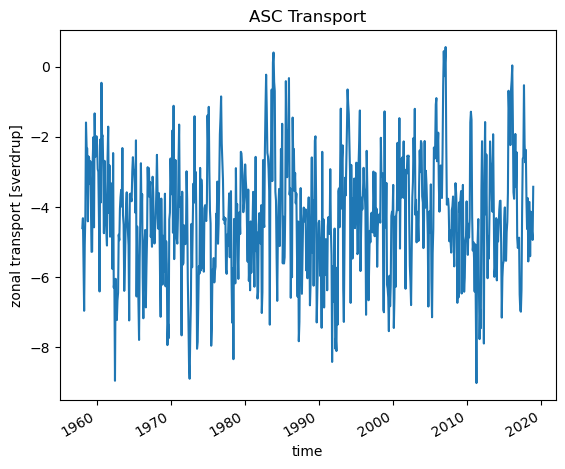

In [118]:
transport.plot()
plt.title('ASC Transport');

### rolling mean the series

In [119]:
# Note we need to first detrend the data:
#trans_d = detrend_dim(transport,'time')
#trans_dr = trans_d.rolling(time=12, center=True).mean()
trans_r = transport.rolling(time=12, center=True).mean()

### Now I will load the temperature time series and Ekman time series to run correlations

## Correlation Formula

In [47]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or 
    for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
     
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

# detrending function:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

## Loading datasets


In [48]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean.cm as cmocean
from collections import OrderedDict
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import gsw
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import timedelta

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
# from cosima_cookbook import distributed as ccd

In [49]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34035/status,
Dashboard: /proxy/34035/status,Workers: 7
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38365,Workers: 7
Dashboard: /proxy/34035/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:41789,Total threads: 4
Dashboard: /proxy/41783/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:39135,


In [50]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

### PREPARE TEMPERATURE

In [52]:
# depth average:
# there is no dzu saved
# calculate grid thickness, adjusted for partial cells:
zlevel1 = 400
zlevel2 = 6000

# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(iaf_cycle3,'st_edges_ocean',master_session,
                 start_time=start_time, end_time=end_time,n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':temp_400m.yt_ocean,'xt_ocean':temp_400m.xt_ocean},axis=[1,2])
# import bathymetry:
ht = cc.querying.getvar(iaf_cycle3,'ht',master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht,other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(iaf_cycle3,'st_ocean',master_session,n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# select correct depths:
thickness = thickness.sel(st_ocean=slice(zlevel1,zlevel2))

# multiply by thickness to avg
temp_400m = (temp_400m*thickness).sum('st_ocean')/thickness.sum('st_ocean')

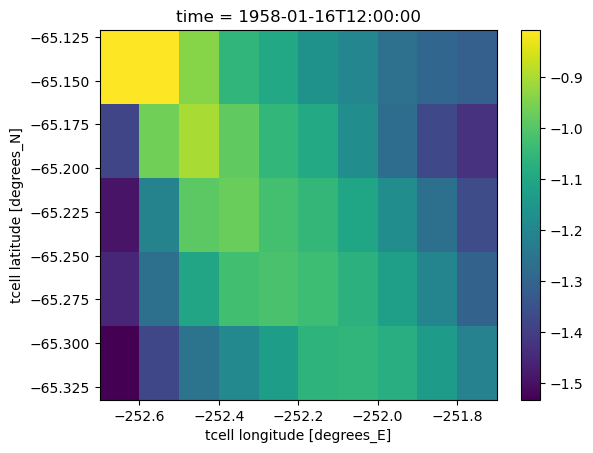

In [53]:
##test if temp is still working after the depth weighting
temp_400m[0,...].plot()

In [54]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_t = cc.querying.getvar('01deg_jra55v13_ryf9091','area_t',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_t = area_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# sum area:
area_t_sum = area_t.sum('xt_ocean').sum('yt_ocean')

# Apply area weight:
temp_400m = (temp_400m*area_t).sum('xt_ocean').sum('yt_ocean')/area_t_sum


In [55]:
temp_400m = temp_400m.load()

#### Detrend time series and apply rolling mean 

In [56]:
# Note we need to first detrend the data:
temp_400m_zad = detrend_dim(temp_400m,'time')
temp_400m_zadr = temp_400m_zad.rolling(time=12, center=True).mean()
temp_400m_r = temp_400m.rolling(time=12, center=True).mean()

### ISOPYCNAL DEPTH 

In [58]:
# calculate density along transect:
# arrays for gsw to use
depth_array = temp_iso*0 + temp_iso.st_ocean
lat_array = temp_iso*0 + temp_iso.yt_ocean
# need to convert practical salinity to absolute salinity:
pressure = gsw.p_from_z(-depth_array,lat_array)
# need to convert practical salinity to absolute salinity:
salt_abs = gsw.SA_from_SP(sal_iso,pressure,sal_iso.xt_ocean,lat_array)
#calculate sigma
sigma0 = gsw.sigma0(salt_abs,temp_iso)

In [59]:
# cut the data BOX 1
#lon_slice  = slice(-253, -251.5) #best
lat_slice  = slice(-65.3, -63)
lon_slice  = slice(-253.5, -251.1)

# topography data:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

fontsize=16

MAKE MASK FOR BOX 1 offshore in between 1000 and 2000 isopycnals

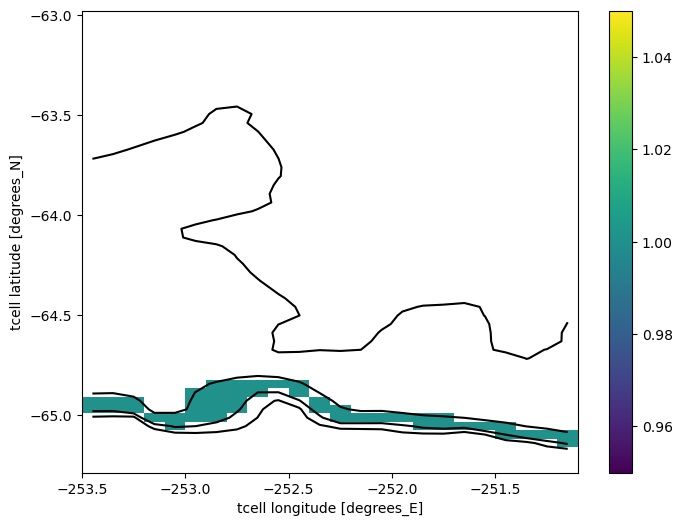

In [60]:
# Mask 

# set to 1 everywhere:
region_mask = ht*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_10002000m.npz')
shelf_mask = contour_file['temp_mask']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

region_mask = region_mask * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)


plt.figure(figsize=(8,6))
region_mask.plot()
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[700,1000,2000,3000],colors='k')
#plt.xlim(-275,-245)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

In [61]:
#apply the mask
sigma0_off = sigma0*region_mask
sigma0_off = sigma0_off.where(sigma0_off!=0)

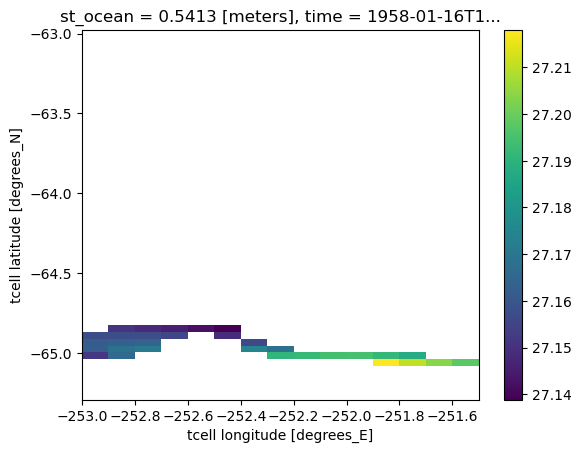

In [62]:
# first time step only:
sigma0_off[0,0,...].plot()

In [63]:
#load
sigma0_off=sigma0_off.load()

Incorporating Adele's method of calculating isopycnals.
Old method works fine, but averaging across lat/lon first means that your final depth values will be limited to values of st_ocean (i.e. quite discrete and widely spaced).
Try to find first depth where density > rho_thresh (27.82 looks like it might be around 500-600 m, i.e. at the depth of shelf break) at each lat/lon position, then average these depths after over lat/lon, which should make the final depth values have more variable values.

Using only the isopycnals that had the highest correlations with previous variables 27.82 and 27.83

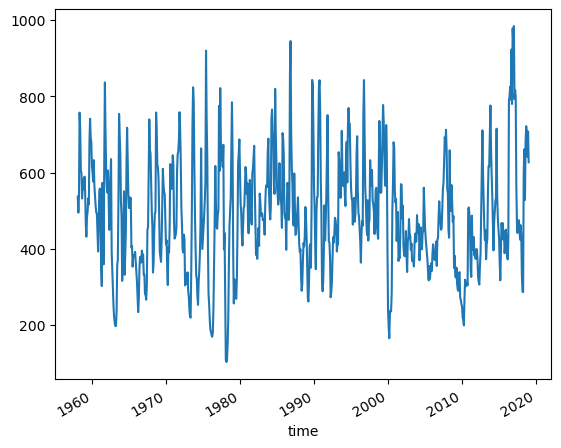

In [64]:
rho_thresh = 27.82

# mask density where < rho_thresh:
sigma0_off_mask = sigma0_off.where(sigma0_off>rho_thresh)
# check this worked:
#sigma0_off_mask[0,:,:,0].plot()

# Now find first depth where sigma0_off_mask is not masked:
depth_array = sigma0_off*0 + sigma0_off.st_ocean
# mask depth array using density threshold:
depth_array_masked = depth_array.where(sigma0_off>rho_thresh)
# find minimum depth at each lat,lon location:
min_depth = depth_array_masked.min(dim='st_ocean')

# now average that minimum depth over lat and lon:
min_depth_avg = min_depth.mean('xt_ocean').mean('yt_ocean')
min_depth_avg.plot()

#rename the isopycnal
iso2782_dth=min_depth_avg

In [65]:
#they are still xarrays until I load them
iso2782_dth=iso2782_dth.load()


### Apply rolling mean 

In [66]:
iso2782_dth_r = iso2782_dth.rolling(time=12, center=True).mean()



In [67]:
# Note we need to first detrend the data:
iso_detrended = detrend_dim(iso2782_dth,'time')

In [68]:
iso_detrended_r=iso_detrended.rolling(time=12, center=True).mean()

## Ekman along the fine slope area 

In [69]:
lon_slice  = slice(-251, 245) 
lat_slice  = slice(-67.5, -63)


# these are the values used by MOM5
sigma = 7.292e-5     # Earth's rotation rate in radians/s
Rearth = 6371.e3 # Earth's radius in m
variable='geolat_c'
geolat_c = cc.querying.getvar(iaf_cycle3,'geolat_c',master_session, n=-1).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

f = 2 * sigma * np.sin(np.deg2rad(geolat_c)) # convert lat in radians


In [72]:
# See https://cosima-recipes.readthedocs.io/en/latest/documented_examples/RelativeVorticity.html#gallery-documented-examples-relativevorticity-ipynb
#ds = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc', combine='by_coords')
#inverse_dxtn = 0.5*(1/ds.dxu + np.roll(1/ds.dxu, 1, axis=1))
#inverse_dyte = 0.5*(1/ds.dyu + np.roll(1/ds.dyu, 1, axis=1))

# use dyu from above, because otherwise the nans from land spread:
inverse_dyte = 0.5*(1/dyu + np.roll(1/dyu, 1, axis=0))
inverse_dxtn = 0.5*(1/dxu + np.roll(1/dxu, 1, axis=0))

# fill land with zeros:
tauy_f_con = tau_y_con/f
tauy_f_con = tauy_f_con.fillna(0)
taux_f_con = tau_x_con/f
taux_f_con = taux_f_con.fillna(0)

In [73]:
# compute derivatives:
#d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=1))*inverse_dxtn
d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=2))*inverse_dxtn
#d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=0))*inverse_dyte
d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=1))*inverse_dyte

# interpolate onto the same grid:
#d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=0))
d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=1))
#d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=1))
d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=2))

# compute curl:
curl_tauf_con = d_dx_tauyf_con - d_dy_tauxf_con
curl_tauf_con = curl_tauf_con.load()

#convert from m/s to m/day
s_day=60*60*24
rho0 = 1035.
ekman_con = curl_tauf_con/rho0*s_day


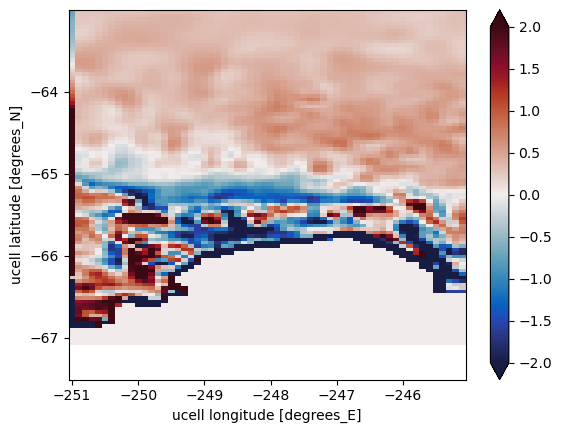

In [74]:
# quick check that this looks ok:
ekman_con.mean('time').plot(vmin=-2,vmax=2,cmap=cmocean.balance)

In [75]:
# cut the data BOX 1
#lon_slice  = slice(-252.3, -250.1) 
lon_slice  = slice(-251, -246) # best -251
#lon_slice  = slice(-253.5, -251.1)
lat_slice  = slice(-65.6, -63)

# topography data:
hu = cc.querying.getvar(iaf_cycle3,'hu' , master_session,n=1)
hu = hu.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
land_maskU = np.squeeze(hu.values)*0
land_maskU[np.isnan(land_maskU)] = 1
land_maskU = np.where(land_maskU==1,land_maskU,np.nan)

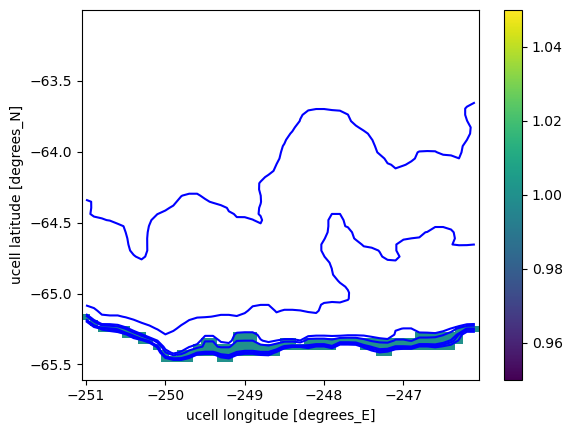

In [76]:
# Mask 

# set to 1 everywhere:
region_mask = hu*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_U5001000m.npz')
shelf_mask = contour_file['temp_maskU']
yu_ocean = contour_file['yu_ocean']
xu_ocean = contour_file['xu_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yu_ocean', yu_ocean), ('xu_ocean', xu_ocean)])

region_mask = region_mask * shelf_mask.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)


#plt.figure(figsize=(8,6))
region_mask.plot()
#i=plt.contour(hu.xu_ocean,hu.yu_ocean,hu,[1000,2000,3000],colors='k')
i=plt.contour(hu.xu_ocean,hu.yu_ocean,hu,[550,600,650,900,1050,2000,3000],colors='b')
#plt.xlim(-275,-245)
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_maskU,colors='grey')

In [77]:
#apply the mask
ekman_con_off = ekman_con*region_mask
ekman_con_off = ekman_con_off.where(ekman_con_off!=0)

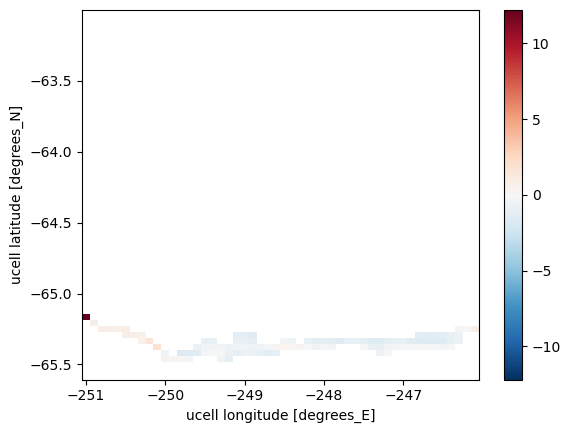

In [78]:
# first time step only:
ek=ekman_con_off.mean('time')
ek.plot()
#ekman_con_off[0,...].plot()

In [79]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_u = cc.querying.getvar('01deg_jra55v13_ryf9091','area_u',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_u = area_u.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)


#add mask to area_t
#NRS added it here because it looks like area weighting also adds zero to masked area instead of nans 
area_u = area_u*region_mask

# sum area:
area_u_sum = area_u.sum('xu_ocean').sum('yu_ocean')

# Apply area weight:
ekman_con_a = (ekman_con_off*area_u).sum('xu_ocean').sum('yu_ocean')/area_u_sum

In [80]:
ekman_con_s = ekman_con_off.sum('yu_ocean').sum('xu_ocean')
ekman_con_s = ekman_con_s.load()

In [81]:
#load the variable
ekman_con_a = ekman_con_a.load()

### detrend ekman series

In [82]:
# Note we need to first detrend the data:
ekman_con_d = detrend_dim(ekman_con_a,'time')
ekman_con_dr = ekman_con_d.rolling(time=12, center=True).mean()
ekman_con_r = ekman_con_a.rolling(time=12, center=True).mean()

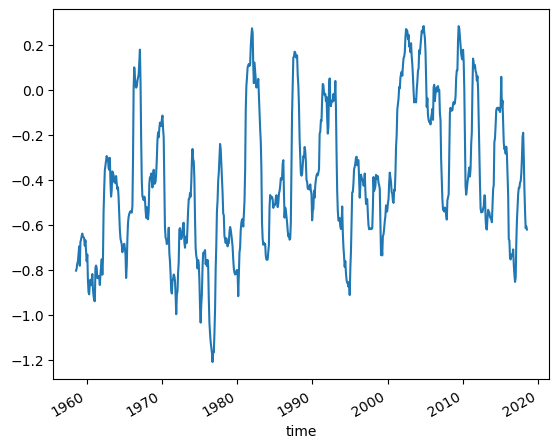

In [83]:
ekman_con_r.plot()


### Correlations

In [1]:
cov1,cor_temp,slope1,intercept1,pval_temp,stderr1 = lag_linregress_3D(temp_400m_zadr,trans_r,lagx=0,lagy=0)
cov2,cor_iso,slope2,intercept2,pval_iso,stderr2 = lag_linregress_3D(iso2782_dth_r,trans_r,lagx=0,lagy=0)
cov2,cor_ekman,slope2,intercept2,pval2,stderr2 = lag_linregress_3D(trans_r,ekman_con_dr,lagx=0,lagy=0)

print('Cor ASC vs TEMP',cor_temp) 
print('Cor ASC vs ISO',cor_iso)
print('Cor EKMAN vs ASC',cor_ekman)

NameError: name 'lag_linregress_3D' is not defined

In [121]:
# AA
s=10;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(temp_400m_zadr,trans_r,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -9 :  <xarray.DataArray ()>
array(-0.3243143)
Coordinates:
    xu_ocean  float64 [degrees_east] -251.5
lag -8 :  <xarray.DataArray ()>
array(-0.30896068)
Coordinates:
    xu_ocean  float64 [degrees_east] -251.5
lag -7 :  <xarray.DataArray ()>
array(-0.2842497)
Coordinates:
    xu_ocean  float64 [degrees_east] -251.5
lag -6 :  <xarray.DataArray ()>
array(-0.25016274)
Coordinates:
    xu_ocean  float64 [degrees_east] -251.5
lag -5 :  <xarray.DataArray ()>
array(-0.20706048)
Coordinates:
    xu_ocean  float64 [degrees_east] -251.5
lag -4 :  <xarray.DataArray ()>
array(-0.15560373)
Coordinates:
    xu_ocean  float64 [degrees_east] -251.5
lag -3 :  <xarray.DataArray ()>
array(-0.09835533)
Coordinates:
    xu_ocean  float64 [degrees_east] -251.5
lag -2 :  <xarray.DataArray ()>
array(-0.03722396)
Coordinates:
    xu_ocean  float64 [degrees_east] -251.5
lag -1 :  <xarray.DataArray ()>
array(0.02418238)
Coordinates:
    xu_ocean  float64 [degrees_east] -251.5
lag 0 :  <xarray.DataArray ()>


In [125]:
# AA
s=10;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(iso2782_dth_r,trans_r,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -9 :  <xarray.DataArray ()>
array(0.53494006)
Coordinates:
    xu_ocean  float64 [degrees_east] -251.5
lag -8 :  <xarray.DataArray ()>
array(0.56461131)
Coordinates:
    xu_ocean  float64 [degrees_east] -251.5
lag -7 :  <xarray.DataArray ()>
array(0.58147037)
Coordinates:
    xu_ocean  float64 [degrees_east] -251.5
lag -6 :  <xarray.DataArray ()>
array(0.58376367)
Coordinates:
    xu_ocean  float64 [degrees_east] -251.5
lag -5 :  <xarray.DataArray ()>
array(0.57092912)
Coordinates:
    xu_ocean  float64 [degrees_east] -251.5
lag -4 :  <xarray.DataArray ()>
array(0.54241063)
Coordinates:
    xu_ocean  float64 [degrees_east] -251.5
lag -3 :  <xarray.DataArray ()>
array(0.49992352)
Coordinates:
    xu_ocean  float64 [degrees_east] -251.5
lag -2 :  <xarray.DataArray ()>
array(0.44365388)
Coordinates:
    xu_ocean  float64 [degrees_east] -251.5
lag -1 :  <xarray.DataArray ()>
array(0.37649293)
Coordinates:
    xu_ocean  float64 [degrees_east] -251.5
lag 0 :  <xarray.DataArray ()>
array(